In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob

airline = pd.read_csv("./customer_airways_data.csv", encoding="iso-8859-1")
reviews = pd.read_csv("./cleaned-reviews.csv")

columns = ["num_passengers", "purchase_lead", "length_of_stay", "flight_hour","flight_duration"]


general_data = {}

for column in columns:
    general_data[column] = {"Máx": airline[column].max(), "Mín": airline[column].min()}


df = pd.DataFrame(general_data)



df.T


,Máx,Mín
num_passengers,9.0,1.00
purchase_lead,867.0,0.00
length_of_stay,778.0,0.00
flight_hour,23.0,0.00
flight_duration,9.5,4.67


In [2]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [3]:
cant_total = len(airline)
cant_internet = airline.sales_channel.value_counts()[0]
cant_mobile = airline.sales_channel.value_counts()[1]

print("Reservas Internet: ",cant_internet * 100 / cant_total,"%","\nReservas Mobile: ",cant_mobile * 100 / cant_total,"%")

Reservas Internet:  88.764 % 
Reservas Mobile:  11.236 %


In [4]:
df_filter = airline.loc[airline.booking_complete > 0,["sales_channel","trip_type"]]

df_quantity_trip = df_filter.groupby(["sales_channel","trip_type"])["trip_type"].count().to_frame().rename(columns={"trip_type": "quantity"})

df_quantity_trip



quantity
sales_channel trip_type           
Internet      CircleTrip         5
              OneWay            18
              RoundTrip       6846
Mobile        OneWay             2
              RoundTrip        607

<AxesSubplot:title={'center':'Preferencia medio de reserva'}, xlabel='Canal de venta', ylabel='Reservas'>

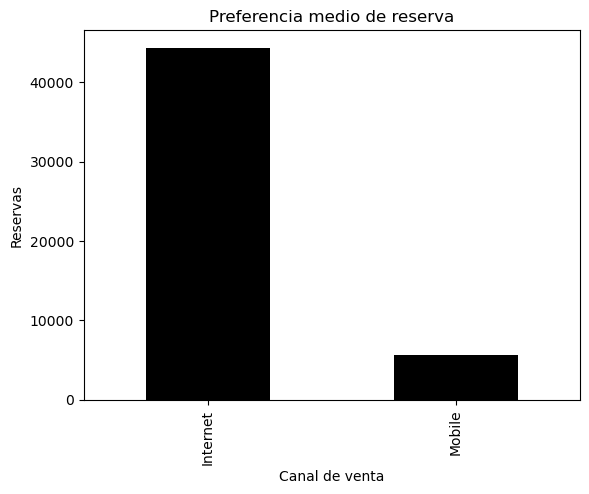

In [5]:
airline.sales_channel.value_counts().plot.bar(color="#000000", title="Preferencia medio de reserva", xlabel="Canal de venta", ylabel="Reservas")


Verificamos si los dias de la semana correspondientes son válidos

In [6]:
days = ["Sun","Mon","Tue","Wed","Thu","Fri","Sat"]

airline["flight_day"].isin(days).value_counts()



True    50000
Name: flight_day, dtype: int64

Verificamos si el pais se registra un pais de origen, con 84 resultados de "not set"

In [7]:
len(airline.loc[airline["booking_origin"] == "(not set)",:])

84


Posibilidad de no completar una reserva "full" de ida y vuelta
Situación: Se ha obtenido un pasaje "full" para un viaje de ida y vuelta --> asiento preferido + comida en el vuelo + equipaje extra.

In [8]:
completed = airline.loc[(airline.wants_extra_baggage>0) & (airline.wants_in_flight_meals > 0) & (airline.wants_preferred_seat>0),["booking_complete"]].sum()
not_completed = airline.loc[(airline.wants_extra_baggage>0) & (airline.wants_in_flight_meals > 0) & (airline.wants_preferred_seat>0),["booking_complete"]]

completed * 100 / len(not_completed)



booking_complete    18.597491
dtype: float64

Que tanto influye el canal de venta en la cancelacion de reserva ?

In [9]:
airline.loc[(airline.wants_extra_baggage > 0) & (airline.wants_in_flight_meals > 0) & (airline.wants_preferred_seat > 0),["booking_complete","sales_channel"]].value_counts()

not_completed_internet = 1469 * 100 / 6260
not_completed_mobile = 162 * 100 / 879

print(not_completed_internet,not_completed_mobile)

23.466453674121407 18.43003412969283


Analizamos la tendencia de rechazo de reserva de acuerdo al paìs de origen

In [10]:
airline_not_booking_complete = airline.loc[airline.booking_complete < 1,:]
airline_not_booking_complete[["route"]].value_counts()


route 
AKLKUL    2113
MELSGN     799
ICNSIN     711
ICNSYD     690
DMKPER     642
          ... 
KNOKTM       1
DACPUS       1
DACPEK       1
DACMRU       1
URTXIY       1
Length: 786, dtype: int64

Analisis de sentimiento y rechazo de reservas por review 

In [11]:
reviews["sentiment"] = 0

for i in range(len(reviews)):
  review = reviews.loc[i, "comments"]
  sentiment = TextBlob(review).polarity
  
  if (sentiment > 0):
    reviews.loc[i,"sentiment"] = "Positive"
  elif (sentiment < 0):
    reviews.loc[i,"sentiment"] = "Negative"
  else:
    reviews.loc[i,"sentiment"] = "Neutro"


Analizamos que pais de origen genera mas comentarios negativos sin estar verificados

In [64]:
serie = reviews.loc[(reviews["sentiment"] == "Negative") & (reviews.verified== False),["country"]].value_counts()
reviews.loc[(reviews["sentiment"] == "Negative") & (reviews.verified== False),"unverified"] = serie

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

In [54]:
reviews.loc[(reviews.country == "Australia") & (reviews.verified == False),["country","sentiment"]].value_counts()

country    sentiment
Australia  Positive     87
           Negative     30
dtype: int64

In [13]:
airline[["trip_type","wants_extra_baggage"]].count()

trip_type              50000
wants_extra_baggage    50000
dtype: int64

In [14]:
len(reviews)


3411